# Deep Learning


## Assignment 1

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './data/'

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 2% change in download progress
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 2 == 0:
            sys.stdout.write('%s%%' % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write('.')
            sys.stdout.flush()
        
        last_percent_reported = percent
    
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download: ', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload completed!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
            'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./data/notMNIST_large.tar.gz
Found and verified ./data/notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J

In [3]:
num_classes = 10
np.random.seed(13)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait. ' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))
    ]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected % folders, one per class. Found % instead' % (
            num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./data/notMNIST_large already present - Skipping extraction of ./data/notMNIST_large.tar.gz
['./data/notMNIST_large/A', './data/notMNIST_large/B', './data/notMNIST_large/C', './data/notMNIST_large/D', './data/notMNIST_large/E', './data/notMNIST_large/F', './data/notMNIST_large/G', './data/notMNIST_large/H', './data/notMNIST_large/I', './data/notMNIST_large/J']
./data/notMNIST_small already present - Skipping extraction of ./data/notMNIST_small.tar.gz
['./data/notMNIST_small/A', './data/notMNIST_small/B', './data/notMNIST_small/C', './data/notMNIST_small/D', './data/notMNIST_small/E', './data/notMNIST_small/F', './data/notMNIST_small/G', './data/notMNIST_small/H', './data/notMNIST_small/I', './data/notMNIST_small/J']


### Problem 1

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded.

In [6]:
for folder in train_folders:
    ex_file = os.listdir(folder)[1000]
    ex_path = os.path.join(folder, ex_file)
    display(Image(filename=ex_path))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memeory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (iamge index, x, y) of floating point values, normalized to have aprroximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

In [7]:
image_size = 28
pixel_depth = 255.0

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) -
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read: ', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected %d < %d' %
                        (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=True):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./data/notMNIST_large/A.pickle.
./data/notMNIST_large/A
Could not read:  ./data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read:  ./data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read:  ./data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling ./data/notMNIST_large/B.pickle.
./data/notMNIST_large/B
Could not read:  ./data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (529

### Problem 2

Let's verify that the data still looks good. Display a sample of the labels and images from the ndarray.

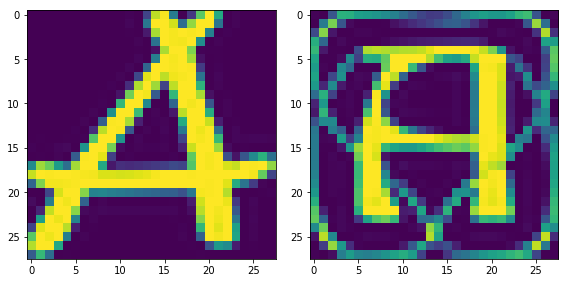

In [9]:
# Just sample arbitary image of 'A' from training set
sample_train_A = pickle.load(open(train_datasets[0], 'rb'))[100]

# Just sample arbitary image of 'A' from test set
sample_test_A = pickle.load(open(test_datasets[0], 'rb'))[100]

fig = plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(sample_train_A)
plt.subplot(122); plt.imshow(sample_test_A)
plt.tight_layout()
plt.show()

### Problem 3

Another check: we expect the data to be balanced across classes. Verify that

In [10]:
# Create a dictionaries whose keys are the letters and values are the number
# of training samples of that letters 
train_samples = { item[-8]: len(pickle.load(open(item,'rb'))) for item in train_datasets}
test_samples = { item[-8]: len(pickle.load(open(item,'rb'))) for item in test_datasets}

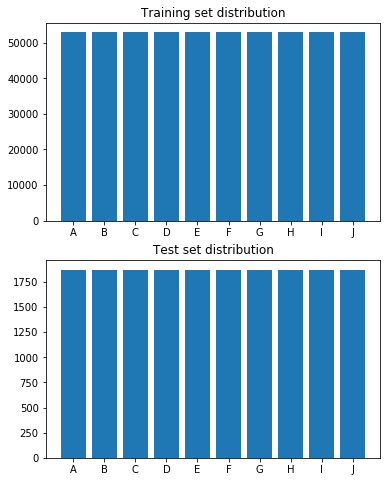

In [11]:
def plot_hist(data_dict, fig_no, title, num_cols=2, num_rows=1):
    """Plot the histogram from an input dictionary"""
    plt.subplot(num_cols, num_rows, fig_no)
    plt.bar(range(len(data_dict)), data_dict.values(), align='center')
    plt.xticks(range(len(data_dict)), list(data_dict.keys()))
    plt.title(title)

fig = plt.figure(figsize=(6, 8))

plot_hist(train_samples, 1, 'Training set distribution')
plot_hist(test_samples, 2, 'Test set distribution')

plt.show()

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The lables will be stored into a separate array of integers 0 though 9

Also create a validation dataset for hyperparameter tuning.

In [12]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        print('data from: %s, %s' % (label, pickle_file))
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # Shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':',e)
            raise
    return valid_dataset, valid_labels, train_dataset, train_labels
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
    train_datasets, train_size, valid_size)

_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

data from: 0, ./data/notMNIST_large/A.pickle
data from: 1, ./data/notMNIST_large/B.pickle
data from: 2, ./data/notMNIST_large/C.pickle
data from: 3, ./data/notMNIST_large/D.pickle
data from: 4, ./data/notMNIST_large/E.pickle
data from: 5, ./data/notMNIST_large/F.pickle
data from: 6, ./data/notMNIST_large/G.pickle
data from: 7, ./data/notMNIST_large/H.pickle
data from: 8, ./data/notMNIST_large/I.pickle
data from: 9, ./data/notMNIST_large/J.pickle
data from: 0, ./data/notMNIST_small/A.pickle
data from: 1, ./data/notMNIST_small/B.pickle
data from: 2, ./data/notMNIST_small/C.pickle
data from: 3, ./data/notMNIST_small/D.pickle
data from: 4, ./data/notMNIST_small/E.pickle
data from: 5, ./data/notMNIST_small/F.pickle
data from: 6, ./data/notMNIST_small/G.pickle
data from: 7, ./data/notMNIST_small/H.pickle
data from: 8, ./data/notMNIST_small/I.pickle
data from: 9, ./data/notMNIST_small/J.pickle
Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match

In [13]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

### Problem 4

Convince yourself that the data is still good after shuffling!

**For me**, I'm going to show some sample pictures in the training and test sets and verify the distributions of those sets

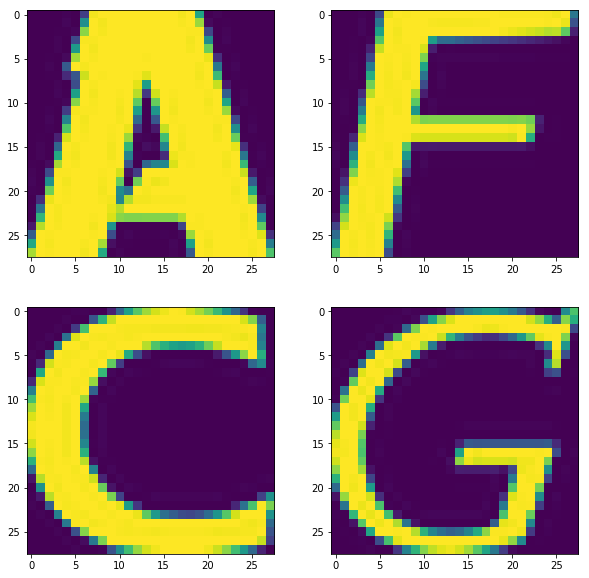

In [14]:
# Show some images from training and test dataset

fig = plt.figure(figsize=(10, 10))

plt.subplot(221); plt.imshow(train_dataset[100])
plt.subplot(222); plt.imshow(train_dataset[500])
plt.subplot(223); plt.imshow(test_dataset[100])
plt.subplot(224); plt.imshow(test_dataset[500])

plt.show()

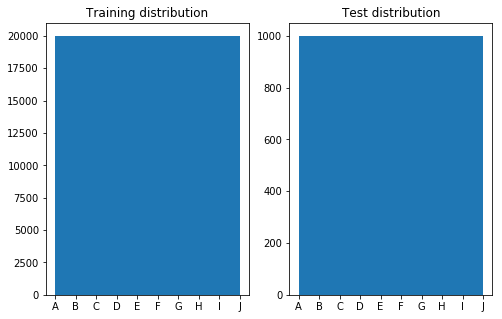

In [15]:
fig = plt.figure(figsize=(8,5))

plt.subplot(121); plt.hist(train_labels); plt.xticks(range(10), [chr(d+65) for d in range(10)]); plt.title('Training distribution')
plt.subplot(122); plt.hist(test_labels); plt.xticks(range(10), [chr(d+65) for d in range(10)]); plt.title('Test distribution')

**Thank God! The datasets are extremely uniformly balanced**

Finally, let's save the data for later reuse:

In [16]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [17]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


### Problem 5

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if the model is expected to use in an environment where there is never an overlap. Measure how much overlap there is between training, validation and test samples.

First of all, write some utilities functions

In [23]:
from hashlib import sha1

def hash_data(D):
    """Returns a dictionary whose keys are indices of the original
    numpy array and values are SHA1 hashes of its elements along
    the first axis
    """
    return {int(idx): sha1(data).hexdigest() for idx, data in enumerate(D)}

def get_intersection(dictA, dictB):
    """Returns numpy array in sorted order that contains
    overlapped elements between two dicts
    """
    A = np.array([d for d in dictA.values()])
    B = np.array([d for d in dictB.values()])
    return np.intersect1d(A, B)

def remove_overlap(original, labels, overlaps, hashm):
    """Remove all elements from 'original' whose hash values
    along the first axis is in `overlaps`"""
    indices = [] # indices of elements to be remove from original
    for overlap in overlaps:
        for search in overlap:
            index = list(hashm.keys())[list(hashm.values()).index(search)]
            indices.append(index)
    data = np.array([data for index, data in enumerate(original) if index not in indices])
    labels = np.array([label for index, label in enumerate(labels) if index not in indices])
    return data, labels

In [24]:
# Hash the datasets
train_hash = hash_data(train_dataset)
valid_hash = hash_data(valid_dataset)
test_hash = hash_data(test_dataset)

In [25]:
# Get the intersections of those datasets
train_valid = get_intersection(train_hash, valid_hash)
train_test = get_intersection(train_hash, test_hash)
test_valid = get_intersection(test_hash, valid_hash)

In [26]:
print('Eliminating overlapped items from train set')
train_set, train_set_labels = remove_overlap(
    train_dataset, train_labels, [train_valid, train_test], train_hash)

print('Eliminating overlapped items from valid set')
valid_set, valid_set_labels = remove_overlap(
    valid_dataset, valid_labels, [train_valid, test_valid], valid_hash)

print('Eliminating overlapped items from test set')
test_set, test_set_labels = remove_overlap(
    test_dataset, test_labels, [train_test, test_valid], test_hash)

Eliminating overlapped items from train set
Eliminating overlapped items from valid set
Eliminating overlapped items from test set


In [29]:
# Save the refined datasets for later uses
output_file = os.path.join(data_root, 'notMNIST_refined.pickle')
print('Pickling {}'.format(output_file))
try:
    f = open(output_file, 'wb')
    save = {
        'train_dataset': train_set,
        'train_labels': train_set_labels,
        'valid_dataset': valid_set,
        'valid_labels': valid_set_labels,
        'test_dataset': test_set,
        'test_labels': test_set_labels
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print('Pickling completed!')
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Pickling ./data/notMNIST_refined.pickle
Pickling completed!
